In [3]:
# !pip install -U scikit-learn
# !pip install torch
# !pip install torchvision
# !pip install torchsummary

In [5]:
# !pip install --upgrade pip

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.datasets import fetch_olivetti_faces
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import urllib
from PIL import Image
from torch import nn
import torchvision.models as models
from torchvision import transforms
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

In [5]:
# load the model
resnet101 = models.resnet101(pretrained=True)

In [6]:
# get the network without the classification layer
# Drop the output layer (the ImageNet classifier)

def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])

model_conv_features = slice_model(resnet101, to_layer=-1).to('cpu')
summary(model_conv_features, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [15]:
# pre-processing required by ResNext
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def retype_image(in_img):
    if np.max(in_img) > 1:
        in_img = in_img.astype(np.uint8)
    else:
        in_img = (in_img * 255.0).astype(np.uint8)
    return in_img

def read_image(in_url):
    # read the image and convert it to PIL image
#     out_im = np.array(Image.open(urllib.request.urlopen(in_url)))[:, :, :3]
    out_im = np.array(Image.open(in_url))[:, :, :3]
#   out_im = np.array(plt.imread(in_url))
    out_im = retype_image(out_im)

  # preprocess the image to prepare it for input to CNN
    out_im = preprocess(Image.fromarray(out_im))
    print(out_im.shape)
    return out_im

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


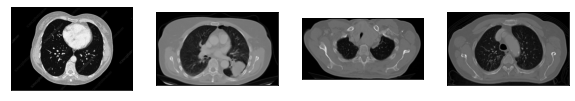

In [20]:
# downlaod and display some example images
# fl = ['https://raw.githubusercontent.com/W281/fileRepository/main/live_session/cat1.png',
#       'https://raw.githubusercontent.com/W281/fileRepository/main/live_session/cat2.png',
#       'https://raw.githubusercontent.com/W281/fileRepository/main/live_session/dog1.png']

fl = ['Data/train/normal/6 - Copy (3).png',
      'Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000061.png',
      'Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000002.png',
      'Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000003.png']

# img1_n = plt.imread(fl[0])
# img2_a = plt.imread(fl[1])
# img3_l = plt.imread(fl[2])
# img4_s = plt.imread(fl[3])

img1_n = read_image(fl[0])
img2_a = read_image(fl[1])
img3_l = read_image(fl[2])
img4_s = read_image(fl[3])

# fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,2))
# ax[0].imshow(img1_n)
# ax[1].imshow(img2_a)
# ax[2].imshow(img3_l)
# ax[3].imshow(img4_s)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,2))
ax[0].imshow(Image.open(fl[0]))
ax[1].imshow(Image.open(fl[1]))
ax[2].imshow(Image.open(fl[2]))
ax[3].imshow(Image.open(fl[3]))

for axi in ax:
  axi.set_xticks([])
  axi.set_yticks([])
plt.show()

In [21]:
# put the model in evaluation mode
resnet101.eval()
# extract the embeddings for the three images
emb1 = model_conv_features(img1_n.unsqueeze(0).to('cpu')).squeeze()
print(emb1.shape)
emb2 = model_conv_features(img2_a.unsqueeze(0).to('cpu')).squeeze()
print(emb2.shape)
emb3 = model_conv_features(img3_l.unsqueeze(0).to('cpu')).squeeze()
print(emb3.shape)
emb4 = model_conv_features(img4_s.unsqueeze(0).to('cpu')).squeeze()
print(emb4.shape)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])


In [24]:
# get the cosine similarity between the images
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

n_a_sim = cos(emb1.unsqueeze(0), emb2.unsqueeze(0))
print('\n Simlarity between N and A Class: {0:.4}\n'.format(n_a_sim.detach().numpy()[0]))

n_l_sim = cos(emb1.unsqueeze(0), emb3.unsqueeze(0))
print('\n Simlarity between N and L Class: {0:.4}\n'.format(n_l_sim.detach().numpy()[0]))

n_s_sim = cos(emb1.unsqueeze(0), emb4.unsqueeze(0))
print('\n Simlarity between N and S Class: {0:.4}\n'.format(n_s_sim.detach().numpy()[0]))




 Simlarity between N and A Class: 0.8025


 Simlarity between N and L Class: 0.7425


 Simlarity between N and S Class: 0.8201



# Extract Features from Images

In [28]:
import os
import numpy as np
from PIL import Image
from skimage.feature import hog
import matplotlib.pyplot as plt

def get_features(folder_path, feat_name='pixels'):
    featurelist = []
    sample_img = None

    if feat_name == 'pixels':
        # Load images from folder_path and stack flattened images into array
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("L")  # Convert to grayscale
            featurelist.append(np.array(image).flatten()[np.newaxis, :])
        features = np.vstack(featurelist)
        sample_img = Image.open(os.path.join(folder_path, os.listdir(folder_path)[0])).convert("L")

    if feat_name == 'hog':
        # Load images from folder_path and stack extracted hog features into array
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("L")  # Convert to grayscale
            fd, hog_image = hog(np.array(image), orientations=4, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), visualize=True, multichannel=False)
            if len(featurelist) == 0:
                sample_img = Image.fromarray(hog_image)
            featurelist.append(fd[np.newaxis, :])

    if feat_name == 'CNN':
        # Similar to before, preprocess images for CNN feature extraction
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("RGB")
            cur_rgb = np.array(image)
            cur_rgb = retype_image(cur_rgb)
            out_im = preprocess(Image.fromarray(cur_rgb))
            featurelist.append(model_conv_features(out_im.unsqueeze(0).to('cpu')).squeeze().detach().numpy())

            if len(featurelist) == 0:
                print('No image for CNN feature')
                print(featurelist[0].shape)

    if sample_img is not None:
        # Plot the sample image
        plt.figure(figsize=(5, 5))
        plt.imshow(sample_img, cmap='gray')
        plt.axis('off')
        plt.show()

    if featurelist:
        return np.vstack(featurelist)

    return None

In [29]:
# plot example features

pixel_features = get_features('Data/train/normal/', feat_name='pixels')
print(pixel_features.shape)

hog_features = get_features(lfw_people.images, feat_name='hog')
print(hog_features.shape)

CNN_features = get_features(lfw_people.images, feat_name='CNN')
print(CNN_features.shape)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 85644 and the array at index 1 has size 441600